In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def smooth(a, kernel):
    b=np.convolve(a,kernel,'same')/np.convolve(np.ones(a.shape),kernel,'same')
    return b

In [3]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system
include_inds = np.array([4, 5, 11, 12, 13, 14, 22, 31, 32, 33, 34, 38, 39, 43, 52, 54])

sigma=20;
short_kernel=(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(np.arange(-60,61)**2)/(2*sigma**2))

In [4]:
from scipy.signal import medfilt
row = dat_xls_file.iloc[include_inds[0]]
folder = row['folder']
fish = row['fish']
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
# subvolt = np.load(dat_dir/'Voltr_subvolt.npz')['subvolt_']
# dff = np.load(dat_dir/'Voltr_spikes.npz')['voltr_']
dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
dff = dff - np.median(dff, axis=1, keepdims=True)
spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')#[:,600:];
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')#[:,600:];

In [5]:
subvolt = dff.copy()
for n, ndff in enumerate(dff):
    subvolt[n, :] = medfilt(ndff, kernel_size=51)

In [6]:
# subvolt = subvolt[:, 600:]
# dff = dff[:, 600:]

/groups/ahrens/home/weiz/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


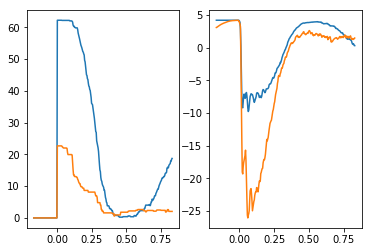

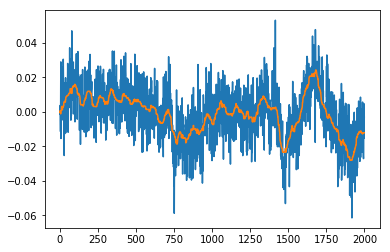

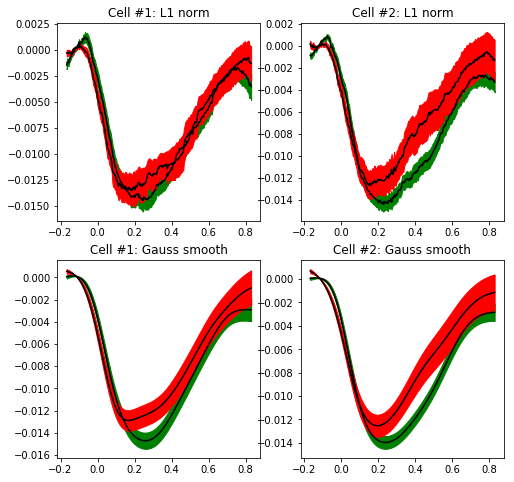

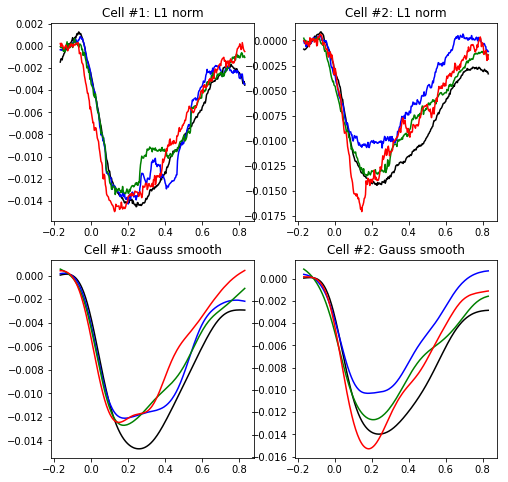

In [7]:
# calculate swimming

ncell   = dff.shape[0]

swim_starts = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==1)[0]
swim_ends   = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==-1)[0]

swim_ends   = swim_ends[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
swim_starts = swim_starts[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]


## swim count in each task period

task_period = frame_stimParams[2,swim_starts]
task_index   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4+(frame_stimParams[4,:]-1)*12;
swim_task_index =  task_index[swim_starts]
swim_count  = np.zeros((len(swim_starts),))

ind_old=0
for s in range(len(swim_starts)):
    ind=swim_task_index[s]
    if (ind>ind_old):
        swim_count[s]=1
        ind_old=ind
    elif (ind==ind_old):
        swim_count[s]=swim_count[s-1]+1

## mean swim ptterns

ave_swim=np.zeros((len(swim_starts),300))
ave_visu=np.zeros((len(swim_starts),300))

for i in range(len(swim_starts)):
    ave_swim[i,:]=frame_swim_tcourse[2,(swim_starts[i]-50):(swim_starts[i]+250)]*100000
    ave_visu[i,:]=-frame_stimParams[0,(swim_starts[i]-50):(swim_starts[i]+250)]*10000

plt.figure(1)
plt.subplot(1,2,1)
plt.plot(np.arange(-50,250)/300,ave_swim[task_period==1,:].mean(axis=0))
plt.plot(np.arange(-50,250)/300,ave_swim[task_period==2,:].mean(axis=0))
plt.subplot(1,2,2)
plt.plot(np.arange(-50,250)/300,ave_visu[task_period==1,:].mean(axis=0))
plt.plot(np.arange(-50,250)/300,ave_visu[task_period==2,:].mean(axis=0))


plt.figure(2)
#time_range=np.arange(1,dff.shape[1])
time_range=np.arange(160000,162000)
plt.plot(dff[0,time_range])
plt.plot(subvolt[0,time_range])
# plt.plot(spk[0, time_range]*dff[0,:].max(), '-k')
## mean swim ptterns

stimParam   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4
ntrials     = int(max(frame_stimParams[4,:])-1)

for c in range(2):

    ave_resp_L1  = np.zeros((len(swim_starts),300));
    ave_resp_dff = np.zeros((len(swim_starts),300));

    for i in range(len(swim_starts)):
        ave_resp_L1[i,:]  = subvolt[c,(swim_starts[i]-50):(swim_starts[i]+250)]
        ave_resp_dff[i,:] = smooth(dff[c,(swim_starts[i]-50):(swim_starts[i]+250)],short_kernel)
    
    ave_resp_L1 -= ave_resp_L1[:,:30].mean(axis=1)[:,None]
    ave_resp_dff -= ave_resp_dff[:,:30].mean(axis=1)[:,None]
    
        
    plt.figure(3,figsize=(8,8)) # Swim average during low gain (green) and high gain (red)
    
    sub_ave1_L1 = ave_resp_L1[task_period==1,:].mean(axis=0) ## events during low gain
    sub_err1_L1 = ave_resp_L1[task_period==1,:].std(axis=0)/np.sqrt(ave_resp_L1[task_period==1,:].shape[0])
    sub_ave2_L1 = ave_resp_L1[task_period==2,:].mean(axis=0) ## events during high gain
    sub_err2_L1 = ave_resp_L1[task_period==2,:].std(axis=0)/np.sqrt(ave_resp_L1[task_period==2,:].shape[0])
    plt.subplot(2,2,c+1).fill_between(np.arange(-50,250)/300,sub_ave1_L1-sub_err1_L1, sub_ave1_L1+sub_err1_L1,color='g')
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,sub_ave1_L1,'k')
    plt.subplot(2,2,c+1).fill_between(np.arange(-50,250)/300,sub_ave2_L1-sub_err2_L1, sub_ave2_L1+sub_err2_L1,color='r')
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,sub_ave2_L1,'k')
    plt.title('Cell #'+str(c+1)+': L1 norm')
              
    sub_ave1_df = ave_resp_dff[task_period==1,:].mean(axis=0) ## events during low gain
    sub_err1_df = ave_resp_dff[task_period==1,:].std(axis=0)/np.sqrt(ave_resp_dff[task_period==1,:].shape[0])
    sub_ave2_df = ave_resp_dff[task_period==2,:].mean(axis=0) ## events during high gain
    sub_err2_df = ave_resp_dff[task_period==2,:].std(axis=0)/np.sqrt(ave_resp_dff[task_period==2,:].shape[0])
    plt.subplot(2,2,c+3).fill_between(np.arange(-50,250)/300,sub_ave1_df-sub_err1_df, sub_ave1_df+sub_err1_df,color='g')
    plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,sub_ave1_df,'k')
    plt.subplot(2,2,c+3).fill_between(np.arange(-50,250)/300,sub_ave2_df-sub_err2_df, sub_ave2_df+sub_err2_df,color='r')
    plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,sub_ave2_df,'k')
    plt.title('Cell #'+str(c+1)+': Gauss smooth')
    
    plt.figure(4,figsize=(8,8)) # Swim count-dependent average (k=low gain, b=1-3 bout, g=4-6 bouts, r=7-9 bouts)
    
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[task_period==1,:].mean(axis=0),'k')
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[((task_period==2) & (swim_count<=3)),:].mean(axis=0),'b')
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[((task_period==2) & (swim_count<=6) & (swim_count>=3)),:].mean(axis=0),'g')
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[((task_period==2) & (swim_count<=9) & (swim_count>=7)),:].mean(axis=0),'r')
    plt.title('Cell #'+str(c+1)+': L1 norm')
              
    plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[task_period==1,:].mean(axis=0),'k')
    plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[((task_period==2) & (swim_count<=3)),:].mean(axis=0),'b')
    plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[((task_period==2) & (swim_count<=6) & (swim_count>=3)),:].mean(axis=0),'g')
    plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[((task_period==2) & (swim_count<=9) & (swim_count>=7)),:].mean(axis=0),'r')
    plt.title('Cell #'+str(c+1)+': Gauss smooth')